Merge from Seurat couldn't handle joining the datasets. Using Scanpy instead.

In [1]:
import os
import tempfile
import scanpy as sc
import scvi
import seaborn as sns
import torch
from rich import print
from scib_metrics.benchmark import Benchmarker


/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
Colonic_Stroma = sc.read_h5ad("/Users/andson/Mouse_Atlas_Intestine/Colonic_Stroma.h5ad")
Epi_Imm_Stro_colon = sc.read_h5ad("/Users/andson/Mouse_Atlas_Intestine/Epi_Imm_Stro_colon.h5ad")
Stromal_Colon = sc.read_h5ad("/Users/andson/Mouse_Atlas_Intestine/Stromal_Colon.h5ad")
Epithelial_Colon = sc.read_h5ad("/Users/andson/Mouse_Atlas_Intestine/Epithelial_Colon.h5ad")
Fibroblasts_DSS = sc.read_h5ad("/Users/andson/Mouse_Atlas_Intestine/Fibroblasts_DSS.h5ad")
Fibroblasts_ctrl = sc.read_h5ad("/Users/andson/Mouse_Atlas_Intestine/Fibroblasts_ctrl.h5ad")
siLP = sc.read_h5ad("/Users/andson/Mouse_Atlas_Intestine/siLP.h5ad")

In [5]:
#Some categories where dropped due to it only being one value. 
# Add the single-category metadata manually
siLP.obs['Treatment'] = 'ctrl'
Fibroblasts_ctrl.obs['Treatment'] = 'ctrl'
Fibroblasts_DSS.obs['Treatment'] = 'DSS'
Stromal_Colon.obs['Treatment'] = 'DSS'
Epithelial_Colon.obs['Treatment'] = 'DSS'

In [6]:
import anndata as ad
import pandas as pd

# Create a dictionary with the dataset names and corresponding AnnData objects
adatas = {
    "Colonic_Stroma": Colonic_Stroma,
    "Epi_Imm_Stro_colon": Epi_Imm_Stro_colon,
    "Stromal_Colon": Stromal_Colon,
    "Epithelial_Colon": Epithelial_Colon,
    "Fibroblasts_DSS": Fibroblasts_DSS,
    "Fibroblasts_ctrl": Fibroblasts_ctrl,
    "siLP" : siLP
}

# Update the observation names with the dataset name prefix
for key in adatas:
    adatas[key].obs_names = [f"{key}_{obs}" for obs in adatas[key].obs_names]

for key in adatas:
    adatas[key].obs['dataset_origin'] = key


# Merge the datasets, preserving the unique observation names
adatas = ad.concat(adatas, label="LI_merged", join="outer")

# Ensure no further duplicates
adatas.obs_names_make_unique()

# If desired, print the updated observation names to check
print(adatas.obs_names)

print(adatas.obs['dataset_origin'])


Index(['Colonic_Stroma_M1_Distal_H2O_AAACATACCGAGAG',
       'Colonic_Stroma_M1_Distal_H2O_AAACGGCTGGTAGG',
       'Colonic_Stroma_M1_Distal_H2O_AAAGACGAGCAGAG',
       'Colonic_Stroma_M1_Distal_H2O_AAAGACGATGCCTC',
       'Colonic_Stroma_M1_Distal_H2O_AAAGAGACTGTTCT',
       'Colonic_Stroma_M1_Distal_H2O_AAAGCCTGTCCGTC',
       'Colonic_Stroma_M1_Distal_H2O_AAATTGACTTCGCC',
       'Colonic_Stroma_M1_Distal_H2O_AACAGCACCTCTAT',
       'Colonic_Stroma_M1_Distal_H2O_AACAGCACGCATCA',
       'Colonic_Stroma_M1_Distal_H2O_AACCAGTGAGAGGC',
       ...
       'siLP_SI_S02_TTTGTTGAGTCATGCT', 'siLP_SI_S02_TTTGTTGCACAAGTGG',
       'siLP_SI_S02_TTTGTTGCACGGTGTC', 'siLP_SI_S02_TTTGTTGCACGTCTCT',
       'siLP_SI_S02_TTTGTTGCATACAGAA', 'siLP_SI_S02_TTTGTTGGTCCATCTC',
       'siLP_SI_S02_TTTGTTGGTCGGATTT', 'siLP_SI_S02_TTTGTTGTCAGCAGAG',
       'siLP_SI_S02_TTTGTTGTCGTTCTGC', 'siLP_SI_S02_TTTGTTGTCTCCGCAT'],
      dtype='object', length=115939)

Colonic_Stroma_M1_Distal_H2O_AAACATACCGAGAG    Colonic_Stroma
Colonic_Stroma_M1_Distal_H2O_AAACGGCTGGTAGG    Colonic_Stroma
Colonic_Stroma_M1_Distal_H2O_AAAGACGAGCAGAG    Colonic_Stroma
Colonic_Stroma_M1_Distal_H2O_AAAGACGATGCCTC    Colonic_Stroma
Colonic_Stroma_M1_Distal_H2O_AAAGAGACTGTTCT    Colonic_Stroma
                                                    ...      
siLP_SI_S02_TTTGTTGGTCCATCTC                             siLP
siLP_SI_S02_TTTGTTGGTCGGATTT                             siLP
siLP_SI_S02_TTTGTTGTCAGCAGAG                             siLP
siLP_SI_S02_TTTGTTGTCGTTCTGC                             siLP
siLP_SI_S02_TTTGTTGTCTCCGCAT                             siLP
Name: dataset_origin, Length: 115939, dtype: object

In [42]:
#import pandas as pd
#adatas.obs_names = pd.Index(adatas.obs_names + '_' + adatas.obs_names.duplicated().cumsum().astype(str))
#print(adatas.obs_names)



Index(['M1_Distal_H2O_AAACATACCGAGAG_0_0', 'M1_Distal_H2O_AAACGGCTGGTAGG_0_0',
       'M1_Distal_H2O_AAAGACGAGCAGAG_0_0', 'M1_Distal_H2O_AAAGACGATGCCTC_0_0',
       'M1_Distal_H2O_AAAGAGACTGTTCT_0_0', 'M1_Distal_H2O_AAAGCCTGTCCGTC_0_0',
       'M1_Distal_H2O_AAATTGACTTCGCC_0_0', 'M1_Distal_H2O_AACAGCACCTCTAT_0_0',
       'M1_Distal_H2O_AACAGCACGCATCA_0_0', 'M1_Distal_H2O_AACCAGTGAGAGGC_0_0',
       ...
       'TTTGGTTAGTACACCT-3_0_0', 'TTTGGTTAGTTCGATC-3_0_0',
       'TTTGGTTCACCTTGTC-3_0_0', 'TTTGGTTCACGGCGTT-3_0_0',
       'TTTGGTTCATGGTAGG-3_0_0', 'TTTGTCAAGAGACTTA-3_0_0',
       'TTTGTCAGTATCAGTC-3_0_0', 'TTTGTCAGTCAGAATA-3_0_0',
       'TTTGTCATCGCTTGTC-3_0_0', 'TTTGTCATCGTCCAGG-3_0_0'],
      dtype='object', length=57678)

In [7]:
#Explore merged data
print("Matrix shape:", adatas.X.shape)
print("Number of non-zero elements:", adatas.X.nnz)
print("Observations (cells):", adatas.obs.shape)
print("Variables (genes):", adatas.var.shape)
print("Layers:", adatas.layers)
print(adatas)

Matrix shape:
(115939, 29549)

Number of non-zero elements: 194239263

Observations (cells):
(115939, 83)

Variables (genes):
(29549, 0)

Layers: Layers with keys:

AnnData object with n_obs × n_vars = 115939 × 29549
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Sample', 'percent.mito', 'Site', 'Treatment', 'batch', 
'Celltype_Stroma_Atlas', 'Celltype_Endothelium_Atlas', 'Celltype_Fibroblast_Atlas', 'percent.mt', 'percent_ribo', 
'celltype', 'unintegrated_clusters', 'seurat_clusters', 'harmony_clusters', 'cellType', 'celltype_general', 
'celltype_integration', 'covariate', 'dataset_origin', 'exptCond', 'tissueLayer', 'condition', 'nCount_SCT', 
'nFeature_SCT', 'SCT_snn_res.0.5', 'SCT_snn_res.0.4', 'celltype_integration_2', 'mouse', 'p28', 'percent_mito', 
'log10GenesPerUMI', 'S.Score', 'G2M.Score', 'Phase', 'pANN', 'DF_classifications', 'RNA_snn_res.0.2', 
'th17_signature1', 'th1_signature1', 'th2_signature1', 'treg_signature1', 'RNA_snn_res.0.8', 'cc.exp', 
'integrated_snn_res.0', 'integrated_snn_res.0.1', 'integrated_snn_res.0.2', 'integrated_snn_res.0.3', 
'integrated_snn_res.0.4', 'integrated_snn_res.0.5', 'integrated_snn_res.0.6', 'integrated_snn_res.0.7', 
'integrated_snn_res.0.8', 'integrated_snn_res.0.9', 'integrated_snn_res.1', 'r1_res.0.3', 'r1_res.0.1', 
'clusterID', 'segment', 'dataset', 'RNA_snn_res.0.5', 'Th1sig1', 'Th2sig1', 'Th17sig1', 'Tfhsig1', 'Tregsig1', 
'NKTsig1', 'IFNsig1', 'Prolif1', 'Tcmsig1', 'Temsig1', 'CD81fib1', 'Fgfr2fib1', 'PDGFRafib1', 'Igfbp5fib1', 
'Pericytes1', 'SMCs1', 'integrated.harmony', 'cell_type_sub', 'cell_type_general', 'LI_merged'
    obsm: 'X_harmony', 'X_pca', 'X_umap.harmony', 'X_umap.unintegrated', 'X_umap'

In [87]:
print(adatas.obsm.keys())

KeysView(AxisArrays with keys: X_harmony, X_pca, X_umap.harmony, X_umap.unintegrated, X_umap)

In [8]:
#remove reductions
# Remove specific reductions from obsm
del adatas.obsm['X_harmony']
del adatas.obsm['X_pca']
del adatas.obsm['X_umap.harmony']
del adatas.obsm['X_umap.unintegrated']

In [89]:
adatas.write('/Users/andson/Mouse_Atlas_Intestine/merged_LI.h5ad')

In [9]:
sc.pp.highly_variable_genes(adatas, n_top_genes=2000, flavor="seurat", batch_key="dataset_origin")
sc.tl.pca(adatas, n_comps=30, use_highly_variable=True)

/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:385: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


In [10]:
adatas = adatas[:, adatas.var.highly_variable].copy()
adatas.obsm["Unintegrated"] = adatas.obsm["X_pca"]


In [11]:
#Scanorama
import scanorama
import numpy as np

# List of adata per batch
batch_cats = adatas.obs.dataset_origin.cat.categories
adata_list = [adatas[adatas.obs.dataset_origin == b].copy() for b in batch_cats]
scanorama.integrate_scanpy(adata_list)

adatas.obsm["Scanorama"] = np.zeros((adatas.shape[0], adata_list[0].obsm["X_scanorama"].shape[1]))
for i, b in enumerate(batch_cats):
    adatas.obsm["Scanorama"][adatas.obs.dataset_origin == b] = adata_list[i].obsm["X_scanorama"]

Found 2000 genes among all datasets
[[0.00000000e+00 1.37590687e-01 6.45406226e-03 7.51162155e-01
  3.59214767e-01 4.89257317e-01 5.92820388e-02]
 [0.00000000e+00 0.00000000e+00 3.88952164e-01 2.46923708e-01
  2.68971579e-01 1.02520724e-01 3.58528767e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 7.59301443e-04
  2.92997363e-04 2.16545424e-01 3.79650721e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  4.74979491e-01 5.05879136e-02 1.16762374e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 2.81570466e-01 7.47143276e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 4.20571815e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]]
Processing datasets (0, 3)
Processing datasets (0, 5)
Processing datasets (3, 4)
Processing datasets (5, 6)
Processing datasets (1, 2)
Processing datasets (0, 4)
Processing datasets (4, 5)
Proc

In [12]:
from harmony import harmonize

adatas.obsm["Harmony"] = harmonize(adatas.obsm["X_pca"], adatas.obs, batch_key="dataset_origin")


	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
Reach convergence after 4 iteration(s).


In [13]:
adatas.X

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 26947510 stored elements and shape (115939, 2000)>

In [14]:
import scvi
adatas.layers["counts"] = adatas.X.copy()
scvi.model.SCVI.setup_anndata(adatas, layer="counts", batch_key="dataset_origin")
vae = scvi.model.SCVI(adatas, gene_likelihood="nb", n_layers=2, n_latent=30)
vae.train()
adatas.obsm["scVI"] = vae.get_latent_representation()

/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 69/69: 100%|██████████| 69/69 [22:23<00:00, 19.10s/it, v_num=1, train_loss_step=607, train_loss_epoch=549]

`Trainer.fit` stopped: `max_epochs=69` reached.


Epoch 69/69: 100%|██████████| 69/69 [22:23<00:00, 19.46s/it, v_num=1, train_loss_step=607, train_loss_epoch=549]


If you want to finetune parameters:

In [15]:
adatas.obs['celltype_integration'] = adatas.obs['celltype_integration'].cat.add_categories('unknown')
adatas.obs['celltype_integration'].fillna('unknown', inplace=True)

lvae = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adatas,
    labels_key="celltype_integration",
    unlabeled_category="unknown",
)
lvae.train(max_epochs=20, n_samples_per_label=100)
adatas.obsm["scANVI"] = lvae.get_latent_representation()

INFO     Training for 20 epochs.                                                                                   


/var/folders/3h/p1kf8x4n11lfvm53slv8wr340000gp/T/ipykernel_76783/420869213.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  adatas.obs['celltype_integration'].fillna('unknown', inplace=True)
/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scvi/data/fields/_dat

Epoch 20/20: 100%|██████████| 20/20 [28:02<00:00, 81.74s/it, v_num=1, train_loss_step=572, train_loss_epoch=539]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [28:02<00:00, 84.11s/it, v_num=1, train_loss_step=572, train_loss_epoch=539]


In [2]:
adatas = sc.read_h5ad("/Users/andson/Mouse_Atlas_Intestine/merged_LI_scib_2.h5ad")


In [3]:
bm = Benchmarker(
    adatas,
    batch_key="dataset_origin",
    label_key="celltype_integration",
    embedding_obsm_keys=["Unintegrated", "Scanorama", "Harmony", "scVI", "scANVI"],
    n_jobs=4,
)
bm.benchmark()

/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:385: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
Embeddings:   0%|          | 0/5 [00:00<?, ?it/s]

INFO     ActNeutrophil consists of a single batch or is too small. Skip.                                           
INFO     AltEnteroPC consists of a single batch or is too small. Skip.                                             


/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     BasalGoblet consists of a single batch or is too small. Skip.                                             
INFO     Bcell_IgM consists of a single batch or is too small. Skip.                                               
INFO     DC consists of a single batch or is too small. Skip.                                                      


/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     EnteroPrecur consists of a single batch or is too small. Skip.                                            


/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(o

INFO     InjuryMono consists of a single batch or is too small. Skip.                                              


/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     Macrophage consists of a single batch or is too small. Skip.                                              


/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     Plasma_IgA consists of a single batch or is too small. Skip.                                              


/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(o

INFO     VascEndo consists of a single batch or is too small. Skip.                                                
INFO     VascSmMuscle1 consists of a single batch or is too small. Skip.                                           
INFO     VascSmMuscle2 consists of a single batch or is too small. Skip.                                           


/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)
/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_pcr_comparison.py:49: UserWarning: PCR comparison score is negative, meaning variance contribution increased after integration. Setting to 0.
  warnings.warn(
Embeddings:  20%|██        | 1/5 [01:56<07:45, 116.40s/it]

INFO     ActNeutrophil consists of a single batch or is too small. Skip.                                           
INFO     AltEnteroPC consists of a single batch or is too small. Skip.                                             


/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     BasalGoblet consists of a single batch or is too small. Skip.                                             
INFO     Bcell_IgM consists of a single batch or is too small. Skip.                                               
INFO     DC consists of a single batch or is too small. Skip.                                                      


/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     EnteroPrecur consists of a single batch or is too small. Skip.                                            


/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(o

INFO     InjuryMono consists of a single batch or is too small. Skip.                                              


/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     Macrophage consists of a single batch or is too small. Skip.                                              


/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     Plasma_IgA consists of a single batch or is too small. Skip.                                              


/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(o

INFO     VascEndo consists of a single batch or is too small. Skip.                                                
INFO     VascSmMuscle1 consists of a single batch or is too small. Skip.                                           
INFO     VascSmMuscle2 consists of a single batch or is too small. Skip.                                           


/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)
Embeddings:  40%|████      | 2/5 [5:46:05<10:09:43, 12194.34s/it]

INFO     ActNeutrophil consists of a single batch or is too small. Skip.                                           
INFO     AltEnteroPC consists of a single batch or is too small. Skip.                                             


/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     BasalGoblet consists of a single batch or is too small. Skip.                                             
INFO     Bcell_IgM consists of a single batch or is too small. Skip.                                               
INFO     DC consists of a single batch or is too small. Skip.                                                      


/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     EnteroPrecur consists of a single batch or is too small. Skip.                                            


/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(o

INFO     InjuryMono consists of a single batch or is too small. Skip.                                              


/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     Macrophage consists of a single batch or is too small. Skip.                                              


/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     Plasma_IgA consists of a single batch or is too small. Skip.                                              


/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(o

INFO     VascEndo consists of a single batch or is too small. Skip.                                                
INFO     VascSmMuscle1 consists of a single batch or is too small. Skip.                                           
INFO     VascSmMuscle2 consists of a single batch or is too small. Skip.                                           


/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)
Embeddings:  60%|██████    | 3/5 [5:47:45<3:42:23, 6671.79s/it]  

INFO     ActNeutrophil consists of a single batch or is too small. Skip.                                           
INFO     AltEnteroPC consists of a single batch or is too small. Skip.                                             
INFO     BasalGoblet consists of a single batch or is too small. Skip.                                             
INFO     Bcell_IgM consists of a single batch or is too small. Skip.                                               
INFO     DC consists of a single batch or is too small. Skip.                                                      


/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     EnteroPrecur consists of a single batch or is too small. Skip.                                            


/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(o

INFO     InjuryMono consists of a single batch or is too small. Skip.                                              


/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     Macrophage consists of a single batch or is too small. Skip.                                              


/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     Plasma_IgA consists of a single batch or is too small. Skip.                                              


/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(o

INFO     VascEndo consists of a single batch or is too small. Skip.                                                
INFO     VascSmMuscle1 consists of a single batch or is too small. Skip.                                           
INFO     VascSmMuscle2 consists of a single batch or is too small. Skip.                                           


/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)
Embeddings:  80%|████████  | 4/5 [5:49:27<1:07:58, 4078.27s/it]

INFO     ActNeutrophil consists of a single batch or is too small. Skip.                                           
INFO     AltEnteroPC consists of a single batch or is too small. Skip.                                             
INFO     BasalGoblet consists of a single batch or is too small. Skip.                                             
INFO     Bcell_IgM consists of a single batch or is too small. Skip.                                               
INFO     DC consists of a single batch or is too small. Skip.                                                      
INFO     EnteroPrecur consists of a single batch or is too small. Skip.                                            


/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(o

INFO     InjuryMono consists of a single batch or is too small. Skip.                                              


/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     Macrophage consists of a single batch or is too small. Skip.                                              


/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     Plasma_IgA consists of a single batch or is too small. Skip.                                              


/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(o

INFO     VascEndo consists of a single batch or is too small. Skip.                                                
INFO     VascSmMuscle1 consists of a single batch or is too small. Skip.                                           
INFO     VascSmMuscle2 consists of a single batch or is too small. Skip.                                           


/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)
Embeddings: 100%|██████████| 5/5 [5:51:07<00:00, 4213.58s/it]  


/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/benchmark/_core.py:268: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Aggregate score' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[_METRIC_TYPE, per_class_score.columns] = _AGGREGATE_SCORE
/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/benchmark/_core.py:268: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Aggregate score' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[_METRIC_TYPE, per_class_score.columns] = _AGGREGATE_SCORE
/Users/andson/miniconda3/envs/mouseatlas/lib/python3.12/site-packages/scib_metrics/benchmark/_core.py:268: FutureWarning: Setting an item of incompatible dtype is deprecated and will

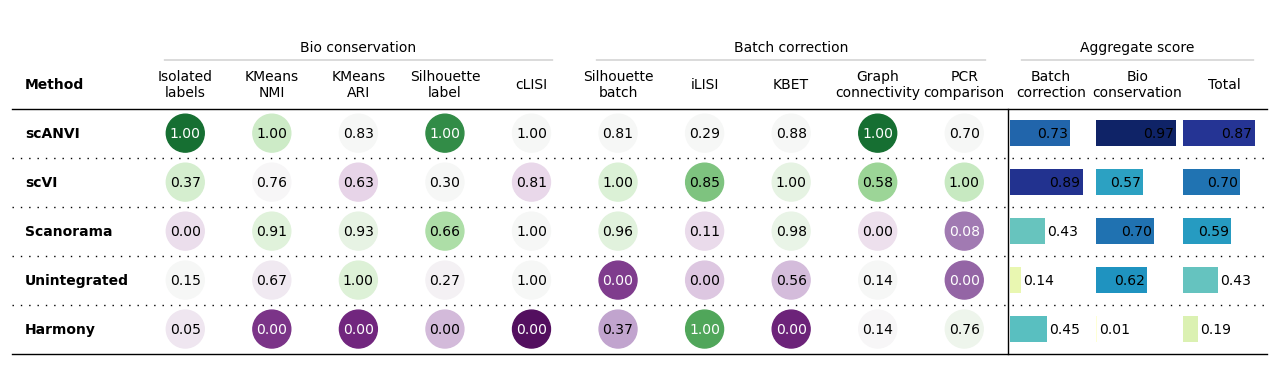

In [4]:
bm.plot_results_table()


In [ ]:
import scvi.autotune import ModelTuner
from ray import tune

In [ ]:
sc.pp.filter_genes(adatas, min_cells = 50)

In [ ]:
model_cls = scvi.model.SCVI
model_cls.setup_anndata(adata, categorical_covariate_keys = ['dataset_origin'],
                             continuous_covariate_keys=['percent.mito', 'percent_ribo'])

tuner = ModelTuner(model_cls) 

In [ ]:
search_space = {
    "n_hidden": tune.choice([92, 128, 192, 256]),
    "n_latent": tune.choice([10, 20, 30, 40, 50, 60]),
    "n_layers": tune.choice([1, 2, 3]),
    "lr": tune.loguniform(1e-4, 1e-2),
    "gene_likelihood": tune.choice(["nb", "zinb"])}

In [ ]:
results = tuner.fit(adata, metric="validation_loss",
                    resources = {'gpu': 1}, #have to specify gpu or might not use
                    search_space = search_space,
                   num_samples = 100,
                   max_epochs = 20)

In [ ]:
best_vl = 10000
best_i = 0
for i, res in enumerate(results.results):
    vl = res.metrics['validation_loss']

    if vl < best_vl:
        best_vl = vl
        best_i = i

In [ ]:
results.results[best_i]


In [ ]:
scvi.model.SCVI.setup_anndata(adatas,
                              categorical_covariate_keys = ['dataset_origin'],
                             continuous_covariate_keys=['percent.mito', 'percent_ribo'])


In [ ]:
model = scvi.model.SCVI(adatas, n_hidden = 256, n_latent = 10, n_layers = 3, gene_likelihood = 'zinb')


In [ ]:
kwargs = {'lr': 0.0026}

In [ ]:
model.train(max_epochs = 200, early_stopping = True, plan_kwargs = kwargs)


In [ ]:
model.save('the_model')


In [ ]:
y = model.history['reconstruction_loss_validation']['reconstruction_loss_validation'].min()


In [ ]:

plt.plot(model.history['reconstruction_loss_train']['reconstruction_loss_train'], label='train')
plt.plot(model.history['reconstruction_loss_validation']['reconstruction_loss_validation'], label='validation')

plt.axhline(y, c = 'k')

plt.legend()
plt.show()

In [ ]:
adatas.write_h5ad('temp.h5ad')


In [ ]:
adatas.obsm['X_scVI'] = model.get_latent_representation()
adatas.obsm['X_scVI'].shape
sc.pp.neighbors(adatas, use_rep = 'X_scVI')
sc.tl.leiden(adatas, resolution = 3, key_added = 'overcluster')
sc.tl.umap(adatas)
adatas.layers['counts'] = adatas.X.copy()
sc.pp.normalize_total(adatas)
sc.pp.log1p(adatas)
adatas.write_h5ad('temp.h5ad')
adatas.obs['low_major'] = adatas.obs.groupby('overcluster')['low_label'].transform(lambda x: x.mode()[0])
sc.pl.umap(adatas, color = ['low_major'], s = 5)


In [ ]:
model = scvi.model.SCVI.load('the_model/', adatas)


In [17]:
adatas.write('/Users/andson/Mouse_Atlas_Intestine/merged_LI_scib_2.h5ad')